In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import squarify

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier 

In [4]:
x_train = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/xtrain_clean.csv')
y_train = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/y_train.csv')
x_test = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/xtest_clean.csv')

In [5]:
y_num = y_train.replace(['functional','non functional', 'functional needs repair'], [0,1,2]) # replace labels by numerical values
data_viz = pd.concat([x_train,y_train['status_group']],axis=1) # data and target in one DF
labels = pd.get_dummies(y_train) #one-hot encoding of target

In [6]:
func = data_viz.loc[data_viz.status_group == 'functional']
non = data_viz.loc[data_viz.status_group == 'non functional']
repair = data_viz.loc[data_viz.status_group == 'functional needs repair']

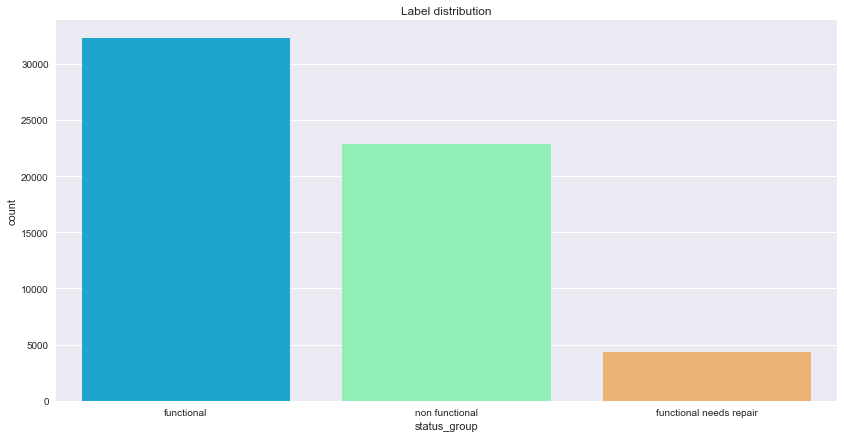

In [7]:
# Few points are labeled need repair, probably will be hardest to predict
plt.figure(figsize=(14,7))
sns.countplot(x='status_group',data=y_train, palette="rainbow")
plt.title("Label distribution")
plt.show()

In [8]:
x_train.columns

Index(['Unnamed: 0', 'id', 'gps_height', 'longitude', 'latitude', 'basin',
       'public_meeting', 'scheme_management', 'construction_year',
       'extraction_type_class', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type',
       'year_recorded', 'date_recordedMonth', 'date_recordedElapsed',
       'population_log', 'age'],
      dtype='object')

## EDA and Feature Selection

In [10]:
cat_df = pd.DataFrame(columns=["Feature", "Cardinality"])
i=0
for col in x_train.columns:
    if (x_train[col].dtype == np.object):
        cat_df.loc[i,"Feature"] = col
        cat_df.loc[i,"Cardinality"] = len(x_train[col].unique())
        i+=1

print("Total cardinality of categorical features:",cat_df.Cardinality.sum())

cat_df

Total cardinality of categorical features: 80


,Feature,Cardinality
0,basin,9
1,scheme_management,12
2,extraction_type_class,7
3,management,12
4,payment_type,7
5,water_quality,8
6,quantity,5
7,source,10
8,source_class,3
9,waterpoint_type,7


## Geographical data plots

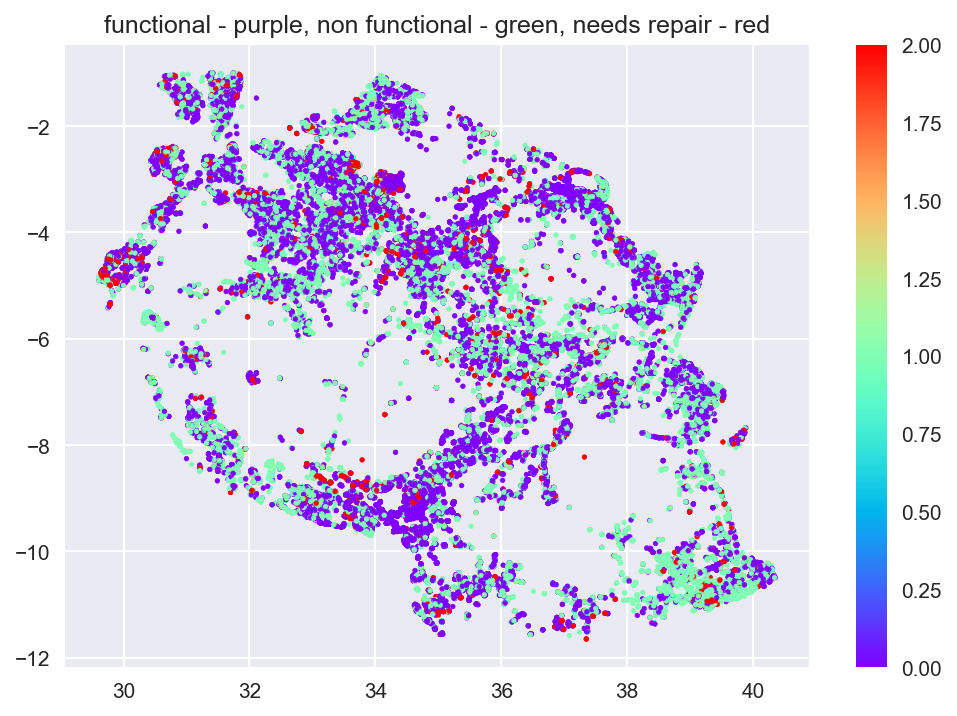

In [11]:
plt.figure(1,dpi=150)
x_geo = x_train.drop(x_train[x_train['longitude'] == 0].index)
y_geo = y_num.drop(x_train[x_train['longitude'] == 0].index)
plt.scatter(x_geo['longitude'], x_geo['latitude'], c = y_geo.iloc[:,1], cmap = 'rainbow', s = 5)
plt.title("functional - purple, non functional - green, needs repair - red")
plt.colorbar()
plt.show()

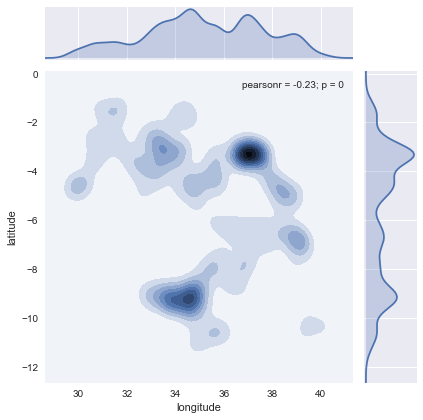

In [12]:
sns.jointplot(y=func['latitude'], x=func['longitude'], kind='kde')
plt.show()

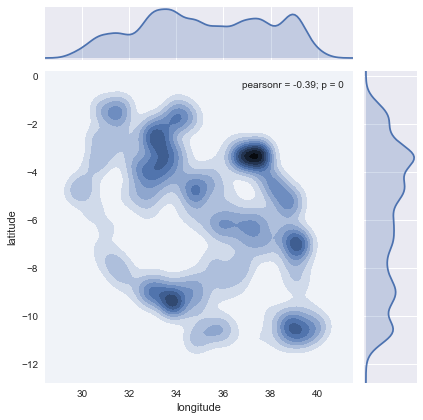

In [13]:
sns.jointplot(y=non['latitude'], x=non['longitude'], kind='kde')
plt.show()

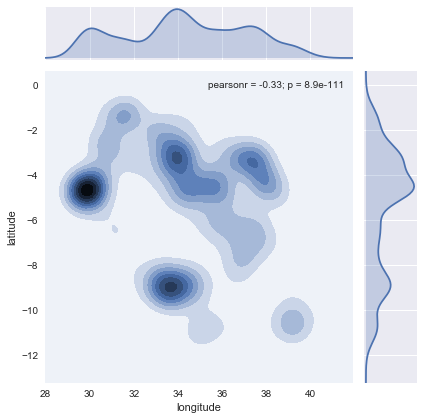

In [14]:
sns.jointplot(y=repair['latitude'], x=repair['longitude'], kind='kde')
plt.show()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


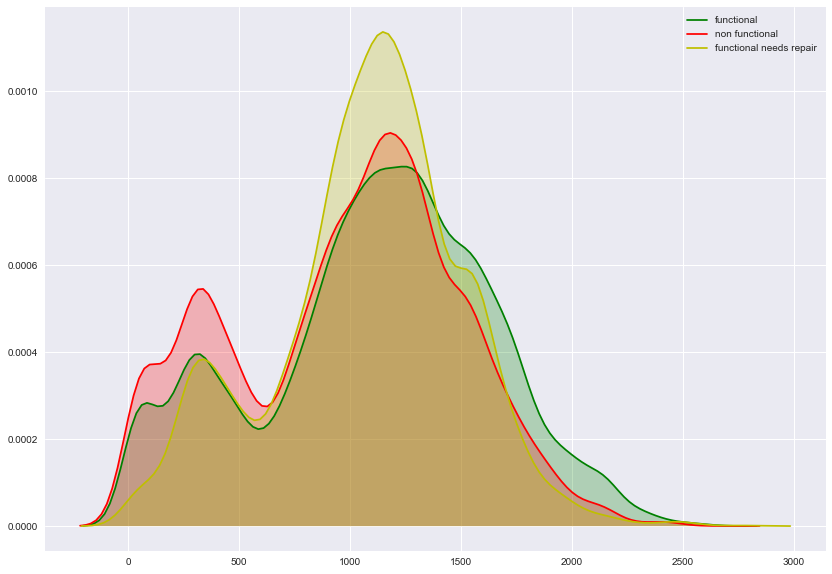

In [15]:
# Height distrinbution per label
plt.figure(figsize=(14,10))

p1=sns.kdeplot(data_viz[['gps_height','status_group']][data_viz.status_group == 'functional']
               [data_viz.gps_height > 0].gps_height, shade=True, color="g",label='functional')
p1=sns.kdeplot(data_viz[['gps_height','status_group']][data_viz.status_group == 'non functional']
               [data_viz.gps_height > 0].gps_height, shade=True, color="r",label='non functional')
p1=sns.kdeplot(data_viz[['gps_height','status_group']][data_viz.status_group == 'functional needs repair']
               [data_viz.gps_height > 0].gps_height, shade=True, color="y",label='functional needs repair')

plt.show()

# Feature selection

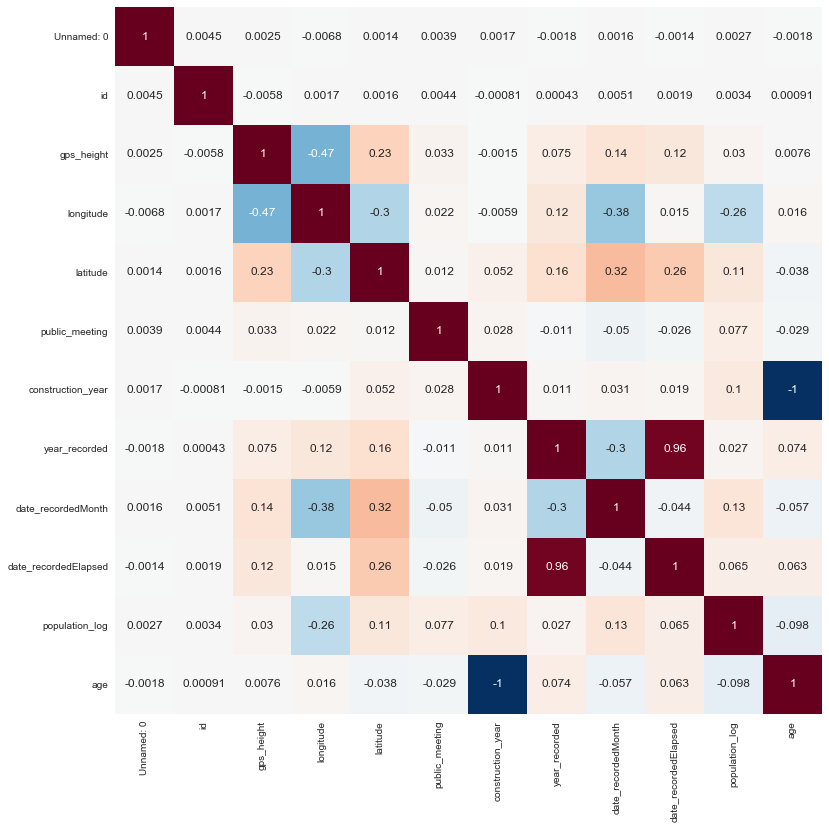

In [16]:
cor = data_viz.corr()
plt.figure(figsize=(14,13))
sns.heatmap(cor, square=True, annot=True, cbar=False)
plt.show()

In [33]:
# Turn all data types into categorical data types
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): 
            print(n)
            df[n] = pd.factorize(df[n])[0]
    return df

In [34]:
x_cats = train_cats(x_train)

basin
scheme_management
extraction_type_class
management
payment_type
water_quality
quantity
source
source_class
waterpoint_type


In [35]:
x_cats.columns

Index(['Unnamed: 0', 'id', 'gps_height', 'longitude', 'latitude', 'basin',
       'public_meeting', 'scheme_management', 'construction_year',
       'extraction_type_class', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type',
       'year_recorded', 'date_recordedMonth', 'date_recordedElapsed',
       'population_log', 'age'],
      dtype='object')

In [36]:
x_cats.head() # or one hot encoding is better?

,Unnamed: 0,id,gps_height,longitude,latitude,basin,public_meeting,scheme_management,construction_year,extraction_type_class,...,water_quality,quantity,source,source_class,waterpoint_type,year_recorded,date_recordedMonth,date_recordedElapsed,population_log,age
0,0,69572,1390.0,34.94,-9.856322,0,1,0,1999.0,0,...,0,0,0,0,0,2011,3,70,4.700480,12.0
1,1,8776,1399.0,34.70,-2.147466,1,1,1,2010.0,0,...,0,1,1,1,0,2013,3,793,5.638355,3.0
2,2,34310,686.0,37.46,-3.821329,2,1,0,2009.0,0,...,0,0,2,1,1,2013,2,784,5.525453,4.0
3,3,67743,263.0,38.49,-11.155298,3,1,0,1986.0,1,...,0,2,3,0,1,2013,1,756,4.077537,27.0
4,4,19728,1300.0,31.13,-1.825359,1,1,2,1997.0,0,...,0,3,1,1,0,2011,7,191,5.525453,14.0


In [ ]:
x_cats.to_csv('txtrain.csv')
x_test_clean.to_csv('txtest.csv')

## Dimensionality Reduction 

In [ ]:
# Defining the normalized
normalizer = Normalizer()

# Fitting normalizer to train set
normalizer.fit(x_train)
norm_train = normalizer.transform(x_train)